## Scripts for Extracting and Proccessing the SIGIR data

In [2]:
import time
import os.path
from requests import get  # to make GET request


def download(url, file_name):
    # open in binary mode
    headers={
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'
    }
    with open(file_name, "wb") as f:
        # get request
        response = get(url,headers=headers)
        # write to file
        f.write(response.content)
        
def make_sp_name(spid):
    return "data/sigir-{0}.html".format(spid)

def get_paper_id(paper_url):
    i = paper_url.find('=')
    j = paper_url.find('&',i)
    pid = paper_url[i+1:j]
    return pid

## Download all the SIGIR proceedings HTML pages from ACM

In [3]:
# These are all the ids to SIGIR proceedings from 1971 to 2016
spids = ['800096','511706','636669','511285','511754','636713','511793','636805','253495','253168',
         '42005','62437','96749','75334','122860','133160','160688','188490','215206','243199','258525','290941'
        ,'564376','383952','345508','312624','290941','860435','1008992','1076034','1148170','1277741','1390334',
         '1571941','1835449','2009916','2348283','2484028','2600428','2766462','2911451']

spfiles = []

spid = '2911451'

# Only downloads pages that are not already/previously downloaded
for spid in spids:
    sigir_url = "http://dl.acm.org/citation.cfm?id={0}&preflayout=flat".format(spid)
    sigir_head_file = make_sp_name(spid)
    spfiles.append(sigir_head_file)
    if not os.path.isfile(sigir_head_file): 
        download(sigir_url, sigir_head_file)
        time.sleep(1)


## Functions for extracting different pieces of data from the SIGIR pages

In [14]:
import re

def extract_url(line):
    i = line.find('citation.cfm')
    j = line.find('"',i+1)
    url = line[i:j]
    return url


def remove_non_article_links(line, spid):
    r = ['flat','tabs','prox']
    r.append(spid)
    
    for w in r:
        if line.find(w)>0:
            line = ""
    
    return line

def strip_cfs(line):
    i = line.find("&CFID")
    sline = line[0:i+1]
    return sline
    

def parse_out_papers(file_name,spid):
    papers = []
    with open(file_name, "r") as f:
        line = f.readline()
        while line:
            if "citation" in line:
                line = remove_non_article_links(line,spid)
                line = strip_cfs(line)
                url = extract_url(line)              
                if url:
                    papers.append('http://dl.acm.org/{0}{1}'.format(url,'&preflayout=flat'))
            line = f.readline()
            
    return papers


def extract_author_id(line):
    i = line.find('author_page.cfm')
    j = line.find('"',i+1)
    aid = line[i:j]
    return aid

def parse_out_authors(file_name):
    authors = []
    with open(file_name, "r") as f:
        line = f.readline()
        while line:
            if "author_page" in line:
                line = strip_cfs(line)
                aid = extract_author_id(line)              
                if aid:
                    authors.append(aid)
            line = f.readline()
            
    return authors


def parse_out_year(file_name):
    year = 0
    reyear = re.compile(r'\d\d\d\d Proceeding')
    with open(file_name, "r") as f:
        line = f.readline()
        while line:
            if " Proceeding" in line:
                d = reyear.search(line)
                if d:
                    year = int(d.group()[0:4])
                    break
            line = f.readline()
    return year


## Calculate which authors had the greatest span between papers at SIGIR

In [38]:
def max_span(year_list):
    #finds the max span between years
    max_span = 0
    years = (0,0)
    
    if len(year_list) == 1:
        return max_span, years
    
    prev_year = year_list[0]
    for curr_year in year_list[1:]:
        curr_span = curr_year-prev_year
        if curr_span > max_span:
            max_span = curr_span
            years = (prev_year,curr_year)
        prev_year = curr_year
    
    return max_span, years


# year author dict
ya = {}

for spf in spfiles:
    authors = parse_out_authors(spf)
    year = parse_out_year(spf)
    ya[year] = authors
    #print(year, len(authors))
    
# author year dict
au = {}    
    
for year in ya:
    for author in ya[year]:
        if author in au:
            yl = au[author]
        else:
            yl = []
        yl.append(year)
        au[author] = yl
        
# Print out the authors where the span is greater than 20 years
        
for author in au:
    (ms,ys) = max_span(au[author])
    if ms > 20:
        print(author, ms, ys)
        


5345
author_page.cfm?id=81100618039 21 (1984, 2005)
author_page.cfm?id=81100609693 24 (1989, 2013)


## Count how many references and how many citations each paper has

In [31]:
def count_references(file_name):
    references = 0
    citations = 0
    year = 0
    
    redate = re.compile(r'\d\d\d\d Article')
    
    do_count = 0 # flag
    
    with open(file_name, "r") as f:
        line = f.readline()
        while line:
            if "REFERENCES" in line:
                do_count = 1
            if ("CITED BY" in line): 
                do_count = 2
            if ("INDEX TERMS" in line):
                do_count = 0
            
            if do_count == 1:
                if '"abstract"' in line:
                    references += 1 
            if do_count == 2:
                a = '"abstract"'
                if a in line:
                    i = line.find(a)
                    j = line.find(' ',i)
                    c = line[i+len(a)+1:j+1]
                                        
                    citations = c.strip()
                    do_count = 0
                    
            if " Article" in line:
                d = redate.search(line)
                if d:
                    year = d.group()[0:4]
                
            line = f.readline()

    if references > 0:
        references = references -1
    return [year, references, citations]

In [32]:
# An example for paper id 2767723 - where it pulls out the year, and the references, and citations.
count_references('data/2767723.html')

['2015', 23, '6']

## for each proceedings html page, extract out all the papers

In [33]:
counts = []
spc = []
for spid in spids:
    sigir_head_file = make_sp_name(spid)
    papers = parse_out_papers(sigir_head_file, spid)
    # for each paper in the proceedings, download the paper
    for p in papers:
        pid = get_paper_id(p)
        paper_file = 'data/{0}.html'.format(pid)
        
        if not os.path.isfile(paper_file): 
            download(p, paper_file)
            time.sleep(2)    
        
        [year, refs,cites] = count_references(paper_file)
        counts.append([pid, year, refs, cites]) 
    
    spc.append(len(papers))


In [45]:
# Save the counts data to file
with open("counts.txt", "w") as f:
    for c in counts:
        f.write("{0} {1} {2} {3}\n".format(c[0], c[1], c[2], c[3] ))


In [34]:
def compute_closest(mref, mcite, threshold):
    
    counts = []

    with open("counts.txt",'r') as f:
        line = f.readline()
        while line:
            (spid, year, refs, cites) = line.split()
            cites = int( cites.replace(',','') )
            refs = int(refs)
            score = ((refs-mref)*(refs-mref)) + ((cites-mcite)*(cites-mcite))
            counts.append([spid, int(year), refs, cites, score])
            if score < threshold:
                print("paper id: {0} year: {1} refs: {2} cites: {3} score: {4}".format( spid, year, refs, cites, score))
                print("http://dl.acm.org/citation.cfm?id={0}".format(spid))
            line = f.readline()


## Closest paper(s) to 40 refs and 40 cites

In [35]:
compute_closest(40,40,10)

paper id: 98244 year: 1989 refs: 40 cites: 41 score: 1
http://dl.acm.org/citation.cfm?id=98244
paper id: 2009998 year: 2011 refs: 39 cites: 40 score: 1
http://dl.acm.org/citation.cfm?id=2009998


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

counts = []

with open("counts.txt",'r') as f:
    line = f.readline()
    while line:
        (spid, year, refs, cites) = line.split()
        cites = int( cites.replace(',','') )
        refs = int(refs)
        counts.append([spid, int(year), refs, cites])
        line = f.readline()

df = pd.DataFrame(counts)
m = df.mean()
print(m)

0            inf
1    2004.648313
2      16.583354
3      20.941893
dtype: float64


## Closes paper(s) to the mean number of refs and mean number of cites

In [36]:
mref = m[2]
mcite = m[3]
print(mref,mcite)
compute_closest(mref,mcite,0.3)

16.5833544786 20.9418929206
paper id: 345562 year: 2000 refs: 17 cites: 21 score: 0.17696992321594995
http://dl.acm.org/citation.cfm?id=345562
paper id: 1076072 year: 2005 refs: 17 cites: 21 score: 0.17696992321594995
http://dl.acm.org/citation.cfm?id=1076072
paper id: 1148233 year: 2006 refs: 17 cites: 21 score: 0.17696992321594995
http://dl.acm.org/citation.cfm?id=1148233


## Random plots

<function matplotlib.pyplot.show>

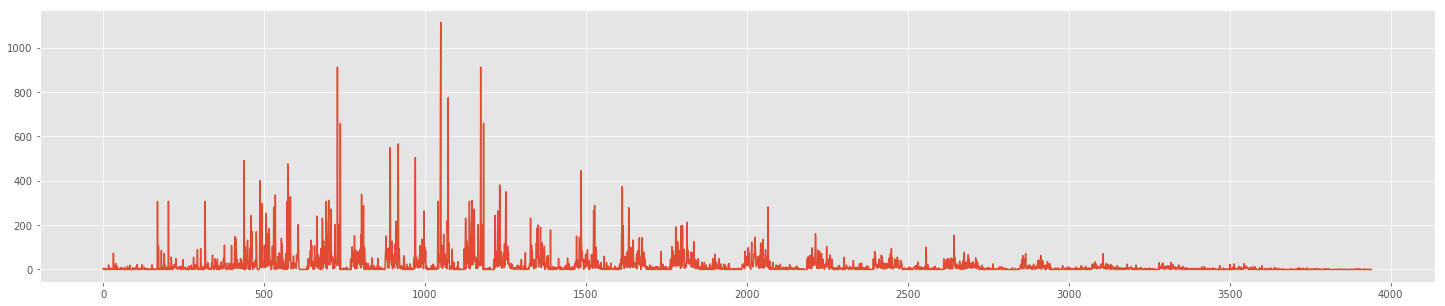

In [46]:
#times = pd.DatetimeIndex(df[1])
#grouped = df.groupby(df[1]).mean()
plt.figure(figsize=(25,5))
plt.plot(df[3])
plt.show

In [39]:
df.head()

,0,1,2,3,4
0,803132,1978,0,4,561.86
1,803133,1978,4,2,516.98
2,803134,1978,6,0,550.42
3,803135,1978,22,2,388.10
4,803136,1978,13,0,451.30


In [60]:
times = pd.DatetimeIndex(df[1])
grouped = df.groupby(df[1]).mean()

In [61]:
print(grouped)

              2          3             4
1                                       
0      0.000000   0.000000    713.380000
1971  16.947368   2.736842    481.312632
1978   6.266667   1.133333    551.513333
1979   9.071429   2.428571    482.934286
1980  23.708333   8.416667   1507.263333
1981  12.523810   3.000000    442.926667
1982  14.714286   3.428571    487.437143
1983  14.964286   3.392857    532.214286
1984  14.925926   1.629630    526.076296
1985  15.187500  11.468750    935.170000
1986  19.057143  10.142857    400.605143
1987  18.757576   5.575758    458.805455
1988  17.955556  10.511111    610.412889
1989  20.464286  13.910714    524.935714
1991  20.000000  17.514286    747.396000
1992  20.060606  45.454545   8314.836970
1993  15.883721  40.813953   3802.736279
1994  17.621622  70.243243  10310.043784
1995  19.804878  43.682927   5217.819024
1996  12.723077  38.676923   7479.985538
1997  19.475000  37.050000   2504.110000
1998  13.729730  64.851351  21870.357297
1999  12.329268 

<function matplotlib.pyplot.show>

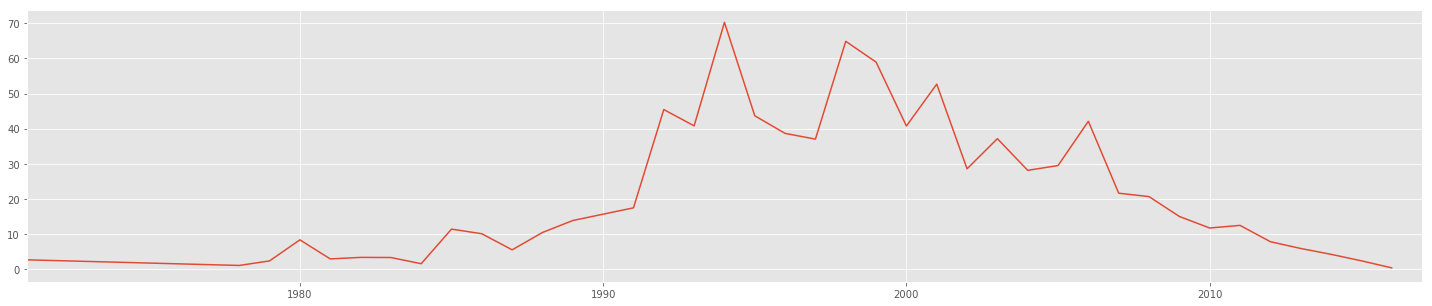

In [62]:
plt.figure(figsize=(25,5))
plt.plot(grouped[3])
plt.xlim([1971,2017])
plt.show